In [14]:
%load_ext watermark
%watermark
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
from sklearn.externals import joblib
import scipy.stats as scs
from scipy.stats import multivariate_normal as mvn
from math import ceil

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm
import copy

import warnings
warnings.filterwarnings("ignore")
import affirm 
from IPython.display import Image

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'CamingoCode', 'legend.frameon': True}
sns.set_style('white', style_kwds)

p=print
p()
%watermark -p pandas,pandas_datareader,numpy,scipy,sklearn,matplotlib,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-04-23T19:52:38-06:00

CPython 3.6.0
IPython 5.1.0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-72-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit

pandas 0.19.2
pandas_datareader 0.3.0.post
numpy 1.12.1
scipy 0.19.0
sklearn 0.18.1
matplotlib 2.0.0
seaborn 0.7.1


In [3]:
DIR = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/'
DIR1 = '/home/cam/Documents/Brian_/HDD_folders/Blackarbs_/Quantinst/'


# Can We Use Mixture Models to Predict Market Bottoms?

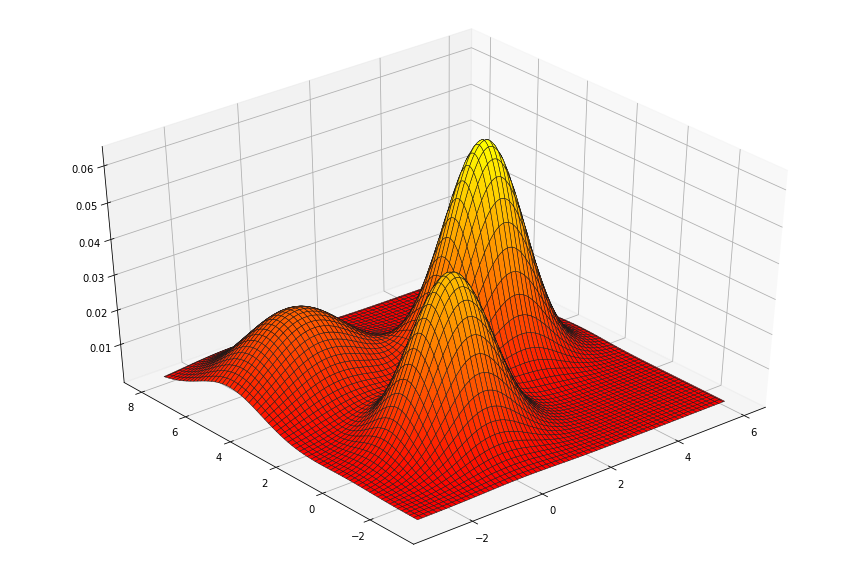

In [4]:
Image(DIR1 + 'Multiple Gaussian PDF.png')

## Why Bother with Mixture Models at all? (Defining the Problem)

Return prediction is difficult.

Consider that the largest hurdle we face when trying to apply predictive techniques to asset returns is nonstationary time series. In __Time Series Analysis (TSA) we observe multiple phenomena that violate the rules of stationarity (non-linear processes, volatility clustering, autocorrelation, etc.)__

__Unfortunately most TSA techniques require that the data is stationary. This is a major weakness of these models.__ 


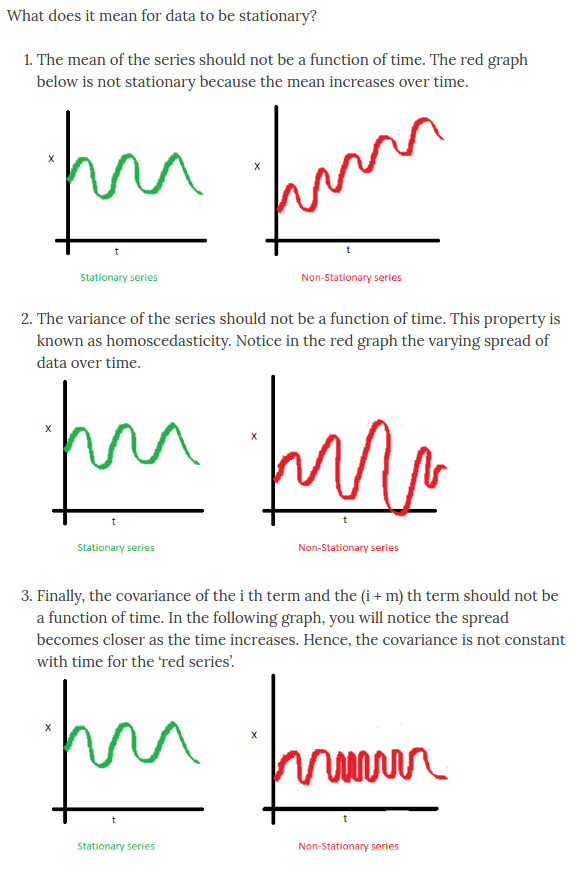

In [6]:
Image('/home/cam/Documents/Brian_/HDD_folders/_Code/Time Series Analysis (TSA)/stationarity infographic screenshot-www.seanabu.com-2016-11-01-14-16-35.png')

## What can we do?

- We need a model that doesn't require stationary data. 
- We need a model that can approximate non-linear distributions
- We need a model that can adapt to changing conditions

## Are mixture models a solution?

#### Mixture models build on several established concepts.
* __Markov models__ - Sequences where future state depends only upon current state aka memoryless processes.
* __Hidden Markov models__ – The true state is unobserved (hidden) but there are observable factors that give us information about the true state.
* __Expectation-Maximization (E-M)__ – Class of algorithms that iterates between computing class parameters and evaluating the likelihood of the data given those parameters. 

## A simple Markov model example

- Assume a sequence of coin tosses with a fair coin.
- What’s the probability of flipping heads on the 10th flip?

In [17]:
# conditional dependence
prob = 0.5
flips = 10
prob**flips

0.0009765625

- Under conditional dependence i.e., coin has memory of past states and future state depends on sequence of past states the probability would be 0.5^10 = 0.000976…
- We know that isn’t true, because the sequence of coin tosses is memoryless and the future state is independent of all past states. Assuming a fair coin, the probability of flipping ‘heads’ on the 10th try is 0.5 no matter the prior sequence. 

## A brief hidden Markov model thought experiment

Assume you’re caring for a newborn baby. 

Most newborns have a limited state space. 

Examples: sleepy, hungry, healthy, sick.

__How can we know which state the baby is in?__

_The baby cannot speak and tell you his/her condition._

_The baby cannot write and tell you his/her condition._

This means that the baby’s true state is __hidden.__ 

To infer the baby’s state we have to look at observable features __(emissions)__ that we believe map back to the true state. 

    - If the baby is hungry it’s likely to cry.
    - If the baby is sick its temperature may rise (in addition to crying).
    - If the baby is sleepy its eyes may get droopy. 

Over time we learn the baby’s emission probabilities 
    - ex. the probability that an observable event ‘crying’ indicates hidden state ‘hungry’. (likely to be high)
Over time we learn the baby’s transition probabilities
    - ex. the probability that the baby will transition to state ‘sleepy’ given the current state is ‘sick’. (likely to be low)

## A Brief Description of Expectation-Maximization

## EM provides general framework for solving problems

Examples include:
    - Filling in missing data from a sample set
    - Discovering values of latent variables
    - Estimating parameters of HMMs
    - Estimating parameters of finite mixtures [models]
    - Unsupervised learning of clusters
    - etc...
    

### How does the EM algorithm work? 

EM is an iterative process that begins with a "naive" or random initialization and then alternates between the expectation and maximization steps until the algorithm reaches convergence. 

Let's walk through a simple example.

## EM Example

In [11]:
## import class heights
f = 'https://raw.githubusercontent.com/BlackArbsCEO/Mixture_Models/K-Means%2C-E-M%2C-Mixture-Models/Class_heights.csv'

data = pd.read_csv(f)

p(data.head())
p()
p(data.groupby('Gender').mean())

   Gender  Height (in)
0    Male           72
1    Male           72
2  Female           63
3  Female           62
4  Female           62

        Height (in)
Gender             
Female    63.785714
Male      71.000000


## With the EM we can estimate the average heights of both classes without labels as long as we guess the correct number of classes

In [12]:
# EM algorithm
# Code sourced from:
#    http://people.duke.edu/~ccc14/sta-663/EMAlgorithm.html

def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        print('\nIteration: ', i)
        print()
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()
        
        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        new_mus = (np.diag(mus)[0], np.diag(mus)[1])
        new_sigs = (np.unique(np.diag(sigmas[0]))[0], np.unique(np.diag(sigmas[1]))[0])
        df = (pd.DataFrame(index=[1, 2]).assign(mus = new_mus).assign(sigs = new_sigs))
        
        xx = np.linspace(0, 100, 100)
        yy = scs.multivariate_normal.pdf(xx, mean=new_mus[0], cov=new_sigs[0])
        
        colors = sns.color_palette('Dark2', 3)
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.set_ylim(-0.001, np.max(yy))
        ax.plot(xx, yy, color=colors[1])
        ax.axvline(new_mus[0], ymin=0., color=colors[1])
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[1])
        lo, hi = ax.get_ylim()
        ax.annotate(f'$\mu_1$: {new_mus[0]:3.2f}', 
                    fontsize=12, fontweight='demi',
                    xy=(new_mus[0], (hi-lo) / 2), 
                    xycoords='data', xytext=(80, (hi-lo) / 2),
                    arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[2])
        
        yy2 = scs.multivariate_normal.pdf(xx, mean=new_mus[1], cov=new_sigs[1])
        
        ax.plot(xx, yy2, color=colors[2])
        ax.axvline(new_mus[1], ymin=0., color=colors[2])
        lo, hi = ax.get_ylim()
        ax.annotate(f'$\mu_2$: {new_mus[1]:3.2f}', 
                    fontsize=12, fontweight='demi',
            xy=(new_mus[1], (hi-lo) / 2), xycoords='data', xytext=(25, (hi-lo) / 2),
            arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy2, alpha=0.5, color=colors[2])
        
        dot_kwds = dict(markerfacecolor='white', markeredgecolor='black', markeredgewidth=1, markersize=10)
        ax.plot(height, len(height)*[0], 'o', **dot_kwds)
        ax.set_ylim(-0.001, np.max(yy2))
        
        
        print(df.T)   
        
        # update complete log likelihoood
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)
        print(f'log_likelihood: {ll_new:3.4f}')
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
        
    return ll_new, pis, mus, sigmas


Iteration:  0

               1           2
mus    61.362928   59.659685
sigs  469.240750  244.382352
log_likelihood: -141.8092

Iteration:  1

              1          2
mus    68.73773  63.620554
sigs  109.85442   7.228183
log_likelihood: -118.0520

Iteration:  2

              1          2
mus   70.569842  63.688825
sigs   4.424452   3.139277
log_likelihood: -100.2591

Iteration:  3

              1          2
mus   70.569842  63.688825
sigs   4.424427   3.139278
log_likelihood: -100.2591


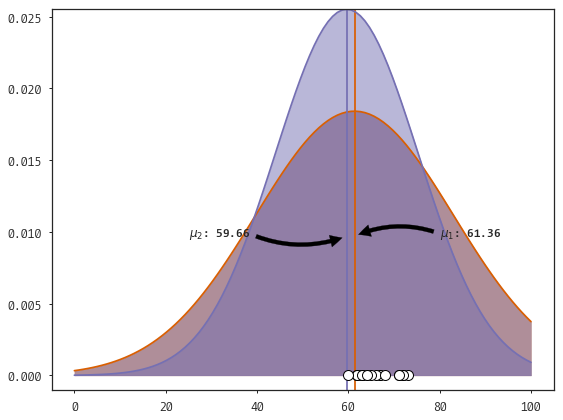

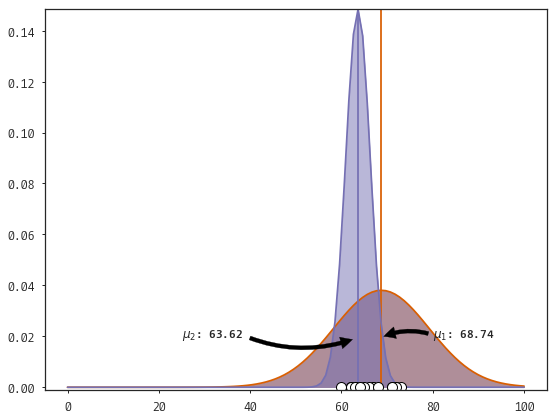

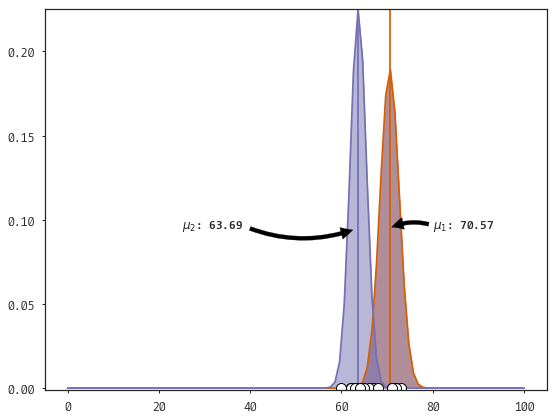

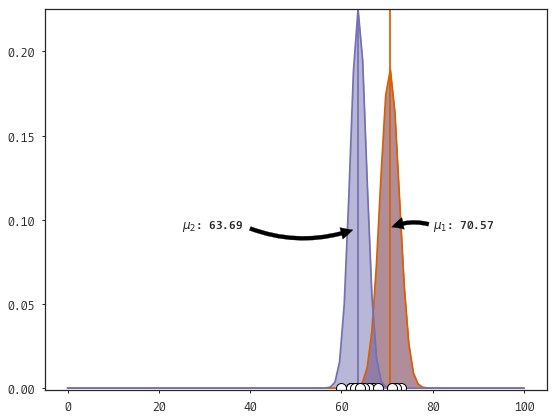

In [15]:
height = data['Height (in)']
n = len(height)

# Ground truthish
_mus = np.array([[0, data.groupby('Gender').mean().iat[0, 0]], 
                 [data.groupby('Gender').mean().iat[1, 0], 0]])
_sigmas = np.array([[[5, 0], [0, 5]], 
                    [[5, 0],[0, 5]]])
_pis = np.array([0.5, 0.5]) # priors

# initial random guesses for parameters
np.random.seed(0)

pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2) * height.std()

# generate our noisy x values
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n))
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])

ll, pis, mus, sigmas = em_gmm_orig(xs, pis, mus, sigmas)

# In the below plots the white dots represent the observed heights.

## How do these concepts fit together?

## What are mixture models and how do they work?

We know that time series exhibit __temporary periods__ where the expected means and variances are stable through time. These periods or __regimes__ can be likened to __hidden states.__

__If we can better estimate an asset's most likely regime or _hidden state_, including the associated means and variances, then our predictive models become more adaptable and will likely improve.__ 

If that's the case, then all we need are __observable variables__ whose behavior allows us to infer the __true hidden state(s).__ 

- Think of an asset’s returns as a sequence of states or __“regimes”__.
- Each regime has its own descriptive statistics including mean and volatility. 
- Examples include __“low-vol”__ vs __“high-vol”__ regimes.
- The model assumes that over time, the asset’s returns will transition between regimes based on probability. 
- Mixture models try to ___estimate the sequence of regimes, each regime’s descriptive attributes, and the transition probabilities between regimes.___
- The most well known is the __Gaussian Mixture Model (GMM).__ 

- GMM assumes __each regime (aka component, class, state) is generated by a Gaussian process__ with discoverable parameters. 
- GMM uses E-M under the hood alternating between estimating the regime parameters (mean, variance) and likelihood that those parameters could generate the data, until convergence or another stopping criteria is met.

## Can GMMs model non-stationary data sets?

Using SPY return data from Yahoo Finance I fit the GMM with 3 components representing low-vol, neutral, and high-vol regimes. 

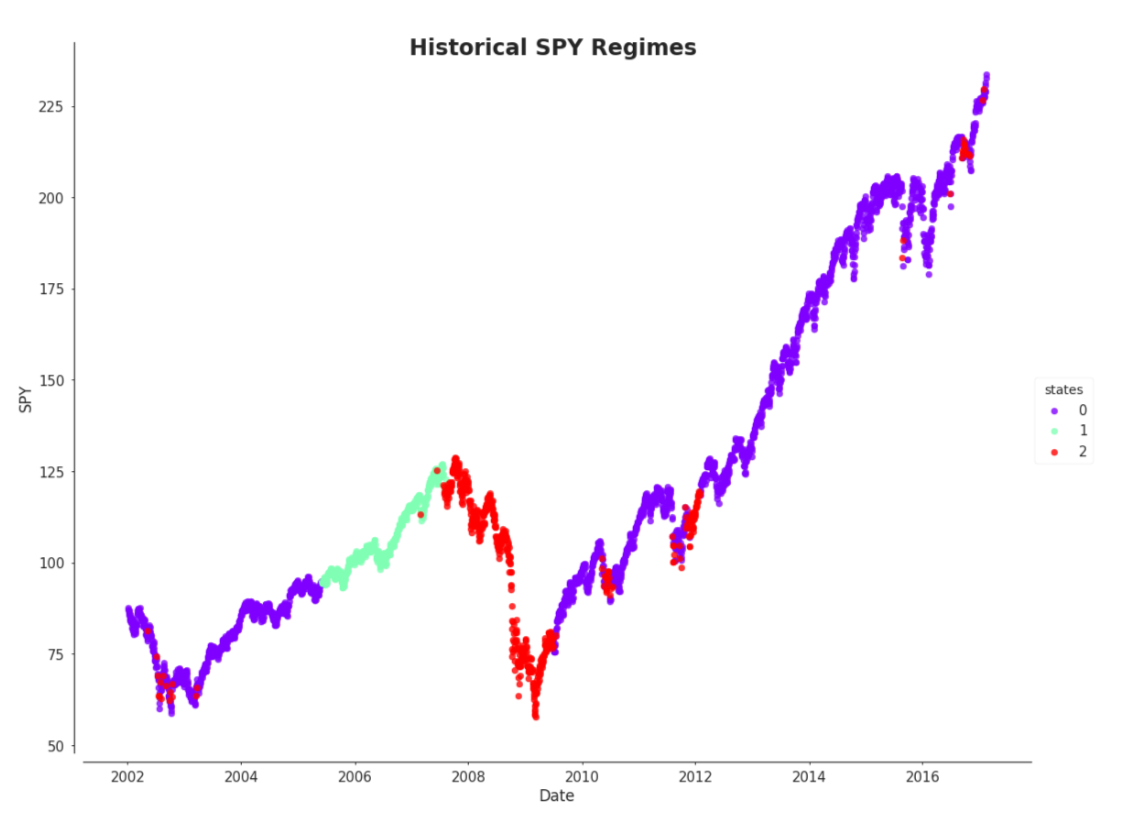

In [30]:
gmm_fit = '/home/cam/Documents/Brian_/HDD_folders/Blackarbs_/Quantinst/gmmk3-spy-fit.png'
gmm_table = '/home/cam/Documents/Brian_/HDD_folders/Blackarbs_/Quantinst/gmmk3-spy-fit-regimes.png'

Image(gmm_fit)

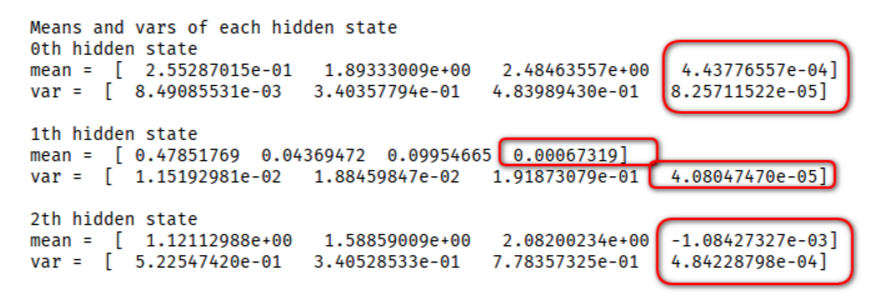

In [21]:
Image(gmm_table)

Notice the 2th hidden state or “regime” has a negative mean return, and the largest variance, which represents our high-vol regime. The 1th hidden state looks like our low-vol regime, and the 0th hidden state is somewhere in between . 

__Thus it does seem that the GMM can fit non-stationary data.__

## Can GMMs approximate nonlinear data distributions?

Using the make moons function from Sklearn we can try and answer this question.

We will use the make moons function because it is a popular example showing the difficulty some algorithms have approximating non-linear data. 

In [26]:
# code sourced from:
#  http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb
from matplotlib.patches import Ellipse 

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, 
                            angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    
    fig, ax = plt.subplots(figsize=(10,7))      
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=dot_size, cmap=cmap, zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=dot_size, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax=ax, alpha=w * w_factor)

First we can see the GMM fit to the make moons data with only 2 components, and the result is predictably bad.

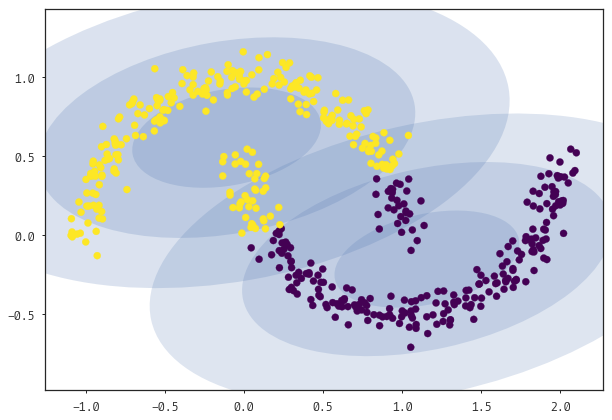

In [27]:
from sklearn.datasets import make_moons

random_state = 0
dot_size = 50
cmap = 'viridis'

X_mn, y_mn = make_moons(500, noise=.07, random_state=random_state)

gmm2 = mix.GaussianMixture(n_components=2, covariance_type='full',
                          random_state=random_state)
plot_gmm(gmm2, X_mn)

Next we fit the GMM to the data with 16 components and clearly it is a much better approximation. 

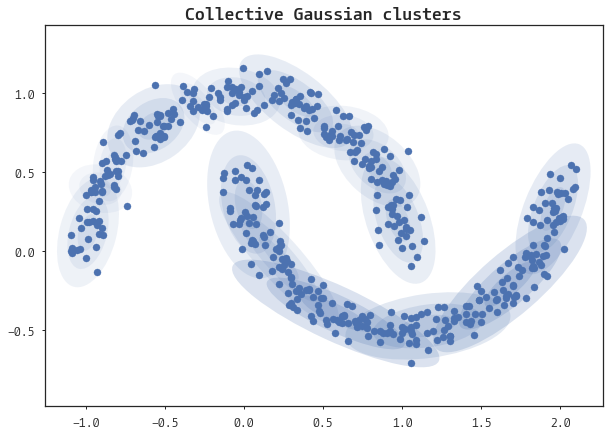

In [28]:
gmm16 = mix.GaussianMixture(n_components=16, covariance_type='full', 
                           random_state=random_state)

plot_gmm(gmm16, X_mn, label=False)
plt.title('Collective Gaussian clusters',
            fontsize=18, fontweight='demi')

The GMM 16 model fits well enough that we can draw __new__ samples that mimic the original data.

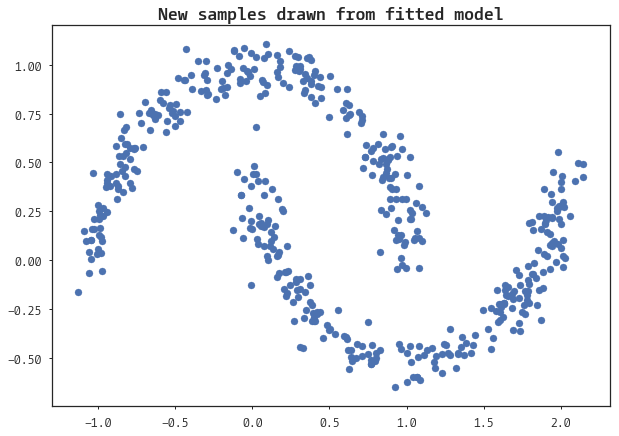

In [31]:
Xnew, ynew = gmm16.sample(500)

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(Xnew[:, 0], Xnew[:, 1]);
ax.set_title('New samples drawn from fitted model',
            fontsize=18, fontweight='demi')

We fit a GMM model with 16 components. Using the fitted model we were able to draw new samples that look just the original data. 

__Thus it appears that the GMM is able to approximate nonlinear data__.

## Now that we see how GMMs apply to time series prediction in theory, we can design an experimental strategy to test.